# **Routing Cables in a Large Wind Farm with Complex Geometry**

In this notebook, we demonstrate how to use `optiwindnet` to route cables for a large wind farm with 122 turbines and 2 substations. The site features a concave cable-laying area and includes an internal obstacle.

The added geometric complexity and increased scale have negligible impact on solving time, as they do not increase the number of variables in the MILP optimization model.

In [1]:
from optiwindnet.api import WindFarmNetwork, Heuristic, MILP, ModelOptions, load_repository

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

### Solvers

Using a *MILP* solver can produce better solutions respect to *Heuristics* and *Metaheuristics*. This notebook uses *COIN-OR CBC*, but examples for other solvers (*gurobi, cplex, ortools, scip, highs*) can be found in the *MILP* notebooks.

> Gurobi and IBM ILOG CPLEX are comercial solvers (academic license available). Google's OR-Tools, COIN-OR CBC, SCIP and HiGHS are open-source software.

### Load input data

>In this example, the `load_repository()` functionality is used to load a prebuilt *Networkx.Graph*. For more details on this functionality look into the notebook about [Load repositories containing location data](api_02-load-repositories.ipynb).

In [3]:
locations = load_repository()

The example location from <https://onlinelibrary.wiley.com/doi/abs/10.1049/rpg2.12593> (Taylor_2023) provides suitable specifications for our purpose; a large wind farm with multiple substations and complex geometry.

In [4]:
wfn = WindFarmNetwork(L=locations.taylor_2023, cables=8)

> Note: To view output plots, trust this notebook first.

<Axes: >

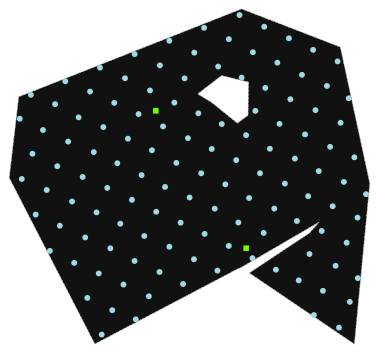

In [5]:
wfn.plot_location()

There are two options for generating an initial solution to warm-start the MILP solver:
- heuristic: `EW_presolver()`
- meta-heuristic: `hgs_multiroot()`

**EW_presolver** has the downside of not limiting the number of feeders, thus the model to be warm-started must also have an unlimited number of feeders. This is usually not a problem, as most cable route sets produced by the MILP solver use the minimum number of feeders or only one more than the minimum.

### Generate the warm-start solution

To generate a warm-start solution, simply run `wfn.optimize()` with the desired solver e.g.:

```python
wfn.optimize(router=router_warmstart)
```

In this example, we use `EW_presolver` to warm-start the optimization model. Alternatively, `HGS_multiroot()` can be used for the same purpose.

The resulting solution is stored within the `wfn` object. The next time `wfn.optimize()` is called, the stored solution (`S` which contains *selected-links*) will be reused as a warm start; provided that the selected router supports warm-starting.


In [6]:
router_warmstart = Heuristic(solver='Esau_Williams')
res_warmstart= wfn.optimize(router=router_warmstart)

### Visualizing the warm-start solution

`S` can be visualized using `wfn.plot_selected_links()`.

> For a detailed explanation and visuals about different graphs and plots in OptiWindNet:
> - look into the notebook about [Plotting](api_05-Plotting.ipynb)
> - read this paper:**To be added: \[link to paper]**

<Axes: >

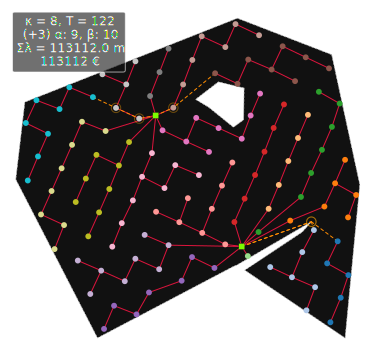

In [7]:
wfn.plot()

### Create MILP model and optimize it using COIN-OR Branch and Cut (CBC)

When initializing a MILP solver three arguments are required to be given:
- solver name
- time limit
- gap

In [8]:
router_milp = MILP(solver_name='cbc', time_limit=300, mip_gap=0.005)

After initializing the router, OptiWindNet sets a set of default options internally.
We can view the router options that were modified to match OptiWindNet’s preferred values using:

```python
router.optiwindnet_default_options
```

This attribute only reflects the options explicitly modified by OptiWindNet during initialization. MILP solvers typically support a much larger set of configurable options, which we can also adjust separately.
For example, in the case of the CBC solver, we can refer to its full list of options here:
[http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf](http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf)

> **Note:** Modifying any of the options originally set by OptiWindNet will not change the values stored in `optiwindnet_default_options`. However, the updated values will be used when solving the optimization problem.

In [9]:
router_milp.optiwindnet_default_options

{'threads': 8,
 'timeMode': 'elapsed',
 'nodeStrategy': 'downFewest',
 'Dins': 'on',
 'VndVariableNeighborhoodSearch': 'on',
 'Rens': 'on',
 'Rins': 'on',
 'pivotAndComplement': 'off',
 'proximitySearch': 'off',
 'gomoryCuts': 'on',
 'mixedIntegerRoundingCuts': 'on',
 'flowCoverCuts': 'on',
 'cliqueCuts': 'off',
 'twoMirCuts': 'off',
 'knapsackCuts': 'off',
 'probingCuts': 'off',
 'zeroHalfCuts': 'off',
 'liftAndProjectCuts': 'off',
 'residualCapacityCuts': 'off'}

Similarly, we can view the default values used for the optimization model via:

```python
router.model_options
```

These `model_options` are not specific to the solver, they define settings related to the structure and behavior of the optimization model itself, rather than the router or solver configuration.

In [10]:
router_milp.model_options

{'topology': <Topology.BRANCHED: 'branched'>,
 'feeder_route': <FeederRoute.SEGMENTED: 'segmented'>,
 'feeder_limit': <FeederLimit.UNLIMITED: 'unlimited'>,
 'balanced': False,
 'max_feeders': 0}

A help for model options can be access via:

```python
ModelOptions.help()
```

In [11]:
ModelOptions.help()

topology in {"radial", "branched"} default: branched
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented"} default: segmented
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3"} default: unlimited
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.

balanced [bool] default: False
    Whether to enforce balanced subtrees (subtree loads differ at most by one unit).

max_feeders [int] default: 0
    Maximum number of feeders (used only if <feeder_limit = "specified">)



Solver options—including those set by OptiWindNet as well as additional configurable parameters—can be modified by creating a **dictionary** and passing it to the router. The same approach applies to **model options**.

In [12]:
solver_options=dict( # these are in addition to the default solver.options
        # if repeatable results are desired, set the seed
        RandomCbcSeed=1234567,
        # CBC works better if the number threads is set to the number of physical cores
        threads=6,
    )

model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )

router_milp = MILP(solver_name='cbc', time_limit=300, mip_gap=0.005, solver_options=solver_options, model_options=model_options)

Run optimizatin with MILP router

In [13]:
# Set logging level to INFO to display messages about solver options
import logging
logging.basicConfig(level=logging.INFO)

# run optimization with the milp router (Set verbose=True to display messages about solver progress)
res = wfn.optimize(router=router_milp, verbose=True)

INFO:root:>>> Using warm start: the model is initialized with the provided solution S <<<
INFO:optiwindnet.MILP.pyomo:>>> cbc solver options <<<
Dins: 'on'
RandomCbcSeed: 1234567
Rens: 'on'
Rins: 'on'
VndVariableNeighborhoodSearch: 'on'
cliqueCuts: 'off'
flowCoverCuts: 'on'
gomoryCuts: 'on'
knapsackCuts: 'off'
liftAndProjectCuts: 'off'
mixedIntegerRoundingCuts: 'on'
nodeStrategy: 'downFewest'
pivotAndComplement: 'off'
probingCuts: 'off'
proximitySearch: 'off'
ratioGap: 0.005
residualCapacityCuts: 'off'
seconds: 300
threads: 6
timeMode: 'elapsed'
twoMirCuts: 'off'
zeroHalfCuts: 'off'



Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Jan  1 1970 

command line - C:\my_program_files\cbc\bin\cbc.exe -threads 6 -timeMode elapsed -nodeStrategy downFewest -Dins on -VndVariableNeighborhoodSearch on -Rens on -Rins on -pivotAndComplement off -proximitySearch off -gomoryCuts on -mixedIntegerRoundingCuts on -flowCoverCuts on -cliqueCuts off -twoMirCuts off -knapsackCuts off -probingCuts off -zeroHalfCuts off -liftAndProjectCuts off -residualCapacityCuts off -RandomCbcSeed 1234567 -seconds 300 -ratioGap 0.005 -printingOptions all -import C:\Users\amia\AppData\Local\Temp\tmpc7743b7n.pyomo.lp -mipstart \Users\amia\AppData\Local\Temp\tmpgjp4zp2i.cbc.soln -stat=1 -solve -solu C:\Users\amia\AppData\Local\Temp\tmpc7743b7n.pyomo.soln (default strategy 1)
threads was changed from 0 to 6
Option for timeMode changed from cpu to elapsed
Option for nodeStrategy changed from fewest to downfewest
Option for Dins changed from off to on
Option for VndVariableNeighborhoodSearch chan

INFO:optiwindnet.MILP.pyomo:>>> Solution <<<
SolutionInfo(runtime=302.18, bound=105145.9, objective=108959.76705329, relgap=0.035002525761868686, termination='maxTimeLimit')



Terse link of the final layout is returned as output of `wfn.optimize()`. If not assigned to a variable (e.g. res), it can be easily accessed via `wfn.terse_links()`.

In [15]:
wfn.G.SolutionInfo

SolutionInfo(runtime=302.18, bound=105145.9, objective=108959.76705329, relgap=0.035002525761868686, termination='maxTimeLimit')

In [ ]:
res

array([  6,   0,   1,  10,   3,  -2,   5,  14,   7,  10,  11,  20,  -2,
        12,  13,  16,  17,  18,  19,  29,  -2,  14,  31,  15,  25,  26,
        27,  28,  -2,  -2,  -2,  41,  42,  34,  35,  36,  37,  38,  -2,
        -2,  -2,  42,  53,  44,  45,  55,  47,  48,  49,  39,  40,  50,
        64,  54,  66,  67,  68,  69,  59,  49,  -2,  60,  51,  62,  65,
        77,  -1,  68,  81,  70,  83,  59,  60,  61,  73,  63,  75,  78,
        79,  80,  -1,  -1,  -1,  82,  83,  84,  85,  74,  87,  90,  91,
        -1,  -1,  -1,  93,  94,  95,  96,  87, 100, 101,  92,  -1,  94,
       103, 104, 114, 106, 100,  -1, 102, 110, 111, 112, 113, 109, 115,
       121, 117, 118, 116, 120])

### Plot the optimized network graph

>Note: The cable cost is equal to the cable length in this example because no cable price data was provided. As a result, OptiWindNet assigns a unit cost (1.0) per unit length by default.

<Axes: >

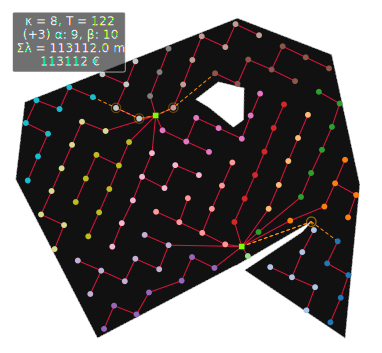

In [ ]:
wfn.plot()